In [3]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Dense, Flatten, Reshape, BatchNormalization,
    LeakyReLU, Conv2D, Conv2DTranspose
)
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [1]:
import os
import numpy as np
from tqdm import tqdm
import glob

# Path to training .npy files
train_npy_dir = r"C:\ct data set\Pancreas-CT data\Split_Data\train"

# Load all .npy files from train
train_files = sorted(glob.glob(os.path.join(train_npy_dir, "*.npy")))
print(f"📁 Found {len(train_files)} training files")

# Load images
train_images = []
for path in tqdm(train_files, desc="📥 Loading Train Images"):
    img = np.load(path)
    train_images.append(img)
 
# Expand dims for CNN input: (N, 128, 128, 1)
train_images = np.expand_dims(np.array(train_images), axis=-1)
print(f"✅ Loaded training image shape: {train_images.shape}")


📁 Found 13259 training files


📥 Loading Train Images: 100%|██████████| 13259/13259 [00:11<00:00, 1191.28it/s]


✅ Loaded training image shape: (13259, 128, 128, 1)


In [3]:
# Convert grayscale (128x128x1) to 3-channel (128x128x3)
train_images_rgb = np.repeat(train_images, 3, axis=-1)

# Now the shape will be (128, 128, 3), which is compatible with ConvNeXt
print(f"Shape after conversion: {train_images_rgb.shape}")

Shape after conversion: (13259, 128, 128, 3)


In [5]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
import numpy as np

# Convert grayscale (128x128x1) to 3-channel (128x128x3)
train_images_rgb = np.repeat(train_images, 3, axis=-1)

# Resize to MobileNetV2 input size (160x160)
train_images_resized = tf.image.resize(train_images_rgb, (160, 160)).numpy()

# Preprocess for MobileNetV2
train_images_preprocessed = preprocess_input(train_images_resized)

# Load MobileNetV2 (without top classifier)
base_model = MobileNetV2(input_shape=(160, 160, 3), include_top=False, weights='imagenet', pooling='avg')
base_model.trainable = False

# Extract features
features = base_model.predict(train_images_preprocessed, batch_size=64, verbose=1)
print(f"✅ Feature shape: {features.shape}")  # Should be (N, 1280)


208/208 ━━━━━━━━━━━━━━━━━━━━ 143s 639ms/step
✅ Feature shape: (13259, 1280)


In [7]:
from sklearn.cluster import KMeans
import numpy as np

# Perform clustering on extracted features
n_clusters = 2  # cancer / no cancer
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
pseudo_labels = kmeans.fit_predict(features)

print(f"✅ Clustering complete. Labels distribution: {np.bincount(pseudo_labels)}")


✅ Clustering complete. Labels distribution: [9456 3803]


In [9]:
import os
import matplotlib.pyplot as plt
from tqdm import tqdm

# Output folder to save clustered images
output_root = r"C:\ct data set\Pancreas-CT data\Clustered_Images"
os.makedirs(output_root, exist_ok=True)

# Create subfolders for each cluster
for cluster_id in np.unique(pseudo_labels):
    os.makedirs(os.path.join(output_root, f"cluster_{cluster_id}"), exist_ok=True)

# Save images into the respective cluster folders
for i, img_array in tqdm(enumerate(train_images[..., 0]), total=len(train_images), desc="📸 Saving clustered images"):
    cluster_id = pseudo_labels[i]
    save_path = os.path.join(output_root, f"cluster_{cluster_id}", f"image_{i:05d}.png")
    plt.imsave(save_path, img_array, cmap='gray')


📸 Saving clustered images: 100%|██████████| 13259/13259 [01:09<00:00, 189.53it/s]


In [11]:
import os
import numpy as np
import cv2
from tqdm import tqdm
import glob

# ===================== CONFIG =====================
gan_img_dir = r"C:\ct data set\Pancreas-CT data\final gan image"
img_size = (128, 128)  # adjust if your GAN outputs other sizes

# ===================== FIND FILES =====================
# Get all .png images in folder
gan_files = sorted(glob.glob(os.path.join(gan_img_dir, "*.png")))
print(f"📁 Found {len(gan_files)} GAN-generated PNG images")

if len(gan_files) == 0:
    raise ValueError(f"⚠️ No PNG files found in {gan_img_dir}")

# ===================== LOAD IMAGES =====================
gan_images = []
for path in tqdm(gan_files, desc="📥 Loading GAN Images"):
    # Load image in grayscale
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        print(f"❌ Warning: Failed to load {path}")
        continue

    # Resize if needed
    if img.shape != img_size:
        img = cv2.resize(img, img_size, interpolation=cv2.INTER_AREA)

    # Normalize [0,255] → [0,1]
    img = img.astype(np.float32) / 255.0

    gan_images.append(img)

# Convert list to array and add channel dimension
gan_images = np.expand_dims(np.array(gan_images), axis=-1)
print(f"✅ Loaded GAN images shape: {gan_images.shape}")


📁 Found 1716 GAN-generated PNG images


📥 Loading GAN Images: 100%|██████████| 1716/1716 [00:07<00:00, 220.02it/s]


✅ Loaded GAN images shape: (1716, 128, 128, 1)


In [13]:
# Convert grayscale (128x128x1) GAN images to 3-channel (128x128x3)
gan_images_rgb = np.repeat(gan_images, 3, axis=-1)

# Now the shape will be (128, 128, 3), which is compatible with ConvNeXt
print(f"Shape after conversion: {gan_images_rgb.shape}")


Shape after conversion: (1716, 128, 128, 3)


In [15]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
import numpy as np

# Assuming you already have `gan_images_rgb` (GAN images in 128x128x3)
# If you're starting from grayscale images, convert to RGB
gan_images_rgb = np.repeat(gan_images, 3, axis=-1)

# Resize to MobileNetV2 input size (160x160)
gan_images_resized = tf.image.resize(gan_images_rgb, (160, 160)).numpy()

# Preprocess for MobileNetV2
gan_images_preprocessed = preprocess_input(gan_images_resized)

# Load MobileNetV2 (without top classifier)
base_model = MobileNetV2(input_shape=(160, 160, 3), include_top=False, weights='imagenet', pooling='avg')
base_model.trainable = False

# Extract features
gan_features = base_model.predict(gan_images_preprocessed, batch_size=64, verbose=1)
print(f"✅ GAN Feature shape: {gan_features.shape}")  # Should be (N, 1280)


27/27 ━━━━━━━━━━━━━━━━━━━━ 18s 620ms/step
✅ GAN Feature shape: (1716, 1280)


In [17]:
from sklearn.cluster import KMeans
import numpy as np

# Assuming `features` is the feature matrix of your extracted features (e.g., from MobileNetV2)
# You can also apply this clustering on both real images (train_images) and GAN-generated images (gan_images)

# Perform clustering on extracted features (real images or GAN images)
n_clusters = 2  # e.g., cancer / no cancer
kmeans = KMeans(n_clusters=n_clusters, random_state=42)



# For GAN images (if you extracted features from GAN images, like `gan_features`)
pseudo_labels_gan = kmeans.fit_predict(gan_features)
print(f"✅ Clustering complete for GAN images. Labels distribution: {np.bincount(pseudo_labels_gan)}")


✅ Clustering complete for GAN images. Labels distribution: [869 847]


In [19]:
import os
import matplotlib.pyplot as plt
from tqdm import tqdm

# Output folder to save clustered GAN images
output_root_gan = r"C:\ct data set\Pancreas-CT data\Clustered_GAN_Images"
os.makedirs(output_root_gan, exist_ok=True)

# Create subfolders for each cluster for GAN images
for cluster_id in np.unique(pseudo_labels_gan):
    os.makedirs(os.path.join(output_root_gan, f"cluster_{cluster_id}"), exist_ok=True)

# Save GAN images into the respective cluster folders
for i, img_array in tqdm(enumerate(gan_images[..., 0]), total=len(gan_images), desc="📸 Saving clustered GAN images"):
    cluster_id = pseudo_labels_gan[i]
    save_path = os.path.join(output_root_gan, f"cluster_{cluster_id}", f"gan_image_{i:05d}.png")
    plt.imsave(save_path, img_array, cmap='gray')


📸 Saving clustered GAN images: 100%|██████████| 1716/1716 [00:05<00:00, 287.54it/s]


In [23]:
import os
import shutil
import glob
from tqdm import tqdm
import matplotlib.pyplot as plt

# Output folder to save merged images
final_output_dir = r"C:\ct data set\Pancreas-CT data\Merged_Clustered_Images"
os.makedirs(final_output_dir, exist_ok=True)

# Define cluster directories for real and GAN images
real_clustered_dir = r"C:\ct data set\Pancreas-CT data\Clustered_Images"
gan_clustered_dir = r"C:\ct data set\Pancreas-CT data\Clustered_GAN_Images"

# Create subfolders for each cluster in the final directory
for cluster_id in np.unique(pseudo_labels):
    os.makedirs(os.path.join(final_output_dir, f"cluster_{cluster_id}"), exist_ok=True)

# Function to move images from one folder to another
def move_images_from_clustered_dir(src_dir, dest_dir, cluster_id, image_type='real'):
    # Get all images in the source directory for the specific cluster
    cluster_dir = os.path.join(src_dir, f"cluster_{cluster_id}")
    if not os.path.exists(cluster_dir):
        print(f"⚠️ Cluster folder {cluster_dir} does not exist.")
        return

    # Get all image files from the cluster folder
    image_files = glob.glob(os.path.join(cluster_dir, "*.png"))
    for image_file in tqdm(image_files, desc=f"📥 Moving {image_type} images from Cluster {cluster_id}", unit="file"):
        # Generate the new path in the final folder
        new_image_name = os.path.basename(image_file)
        dest_path = os.path.join(dest_dir, f"cluster_{cluster_id}", new_image_name)
        
        # Move image to final directory
        shutil.copy(image_file, dest_path)

# Move Real Images
for cluster_id in np.unique(pseudo_labels):
    move_images_from_clustered_dir(real_clustered_dir, final_output_dir, cluster_id, image_type='real')

# Move GAN Images
for cluster_id in np.unique(pseudo_labels_gan):
    move_images_from_clustered_dir(gan_clustered_dir, final_output_dir, cluster_id, image_type='GAN')

# Check the number of files in the final output folder
for cluster_id in np.unique(pseudo_labels):
    cluster_dir = os.path.join(final_output_dir, f"cluster_{cluster_id}")
    print(f"✅ Cluster {cluster_id}: {len(os.listdir(cluster_dir))} images")

print("\n🎉 Merging complete!")


📥 Moving GAN images from Cluster 1: 100%|██████████| 847/847 [00:00<00:00, 1113.58file/s]

✅ Cluster 0: 10325 images
✅ Cluster 1: 4650 images

🎉 Merging complete!


Found 14975 images belonging to 2 classes.



Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 160, 160,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convnext_tiny_pres… │ (None, 160, 160,  │          0 │ input_layer[0][0] │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convnext_tiny_stem  │ (None, 40, 40,    │      4,896 │ convnext_tiny_pr… │
│ (Sequential)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convnext_tiny_stag… │ (None, 40, 40,    │      4,800 │ convnext_tiny_st… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convnext_tiny_stag… │ (None, 40, 40,    │        192 │ convnext_tiny_st… │
│ (LayerNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convnext_tiny_stag… │ (None, 40, 40,    │     37,248 │ convnext_tiny_st… │
│ (Dense)             │ 384)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convnext_tiny_stag… │ (None, 40, 40,    │          0 │ convnext_tiny_st… │
│ (Activation)        │ 384)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convnext_tiny_stag… │ (None, 40, 40,    │     36,960 │ convnext_tiny_st… │
│ (Dense)             │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convnext_tiny_stag… │ (None, 40, 40,    │         96 │ convnext_tiny_st… │
│ (LayerScale)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convnext_tiny_stag… │ (None, 40, 40,    │          0 │ convnext_tiny_st… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 40, 40,    │          0 │ convnext_tiny_st… │
│                     │ 96)               │            │ convnext_tiny_st… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convnext_tiny_stag… │ (None, 40, 40,    │      4,800 │ add[0][0]         │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convnext_tiny_stag… │ (None, 40, 40,    │        192 │ convnext_tiny_st… │
│ (LayerNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convnext_tiny_stag… │ (None, 40, 40,    │     37,248 │ convnext_tiny_st… │
│ (Dense)             │ 384)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convnext_tiny_stag… │ (None, 40, 40,    │          0 │ convnext_tiny_st… │
│ (Activation)        │ 384)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convnext_tiny_stag… │ (None, 40, 40,    │     36,960 │ convnext_tiny_st… │
│ (Dense)             │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convnext_tiny_stag… │ (None, 40, 40,    │         96 │ convnext_tiny_st

 Total params: 28,214,369 (107.63 MB)

 Trainable params: 394,241 (1.50 MB)

 Non-trainable params: 27,820,128 (106.13 MB)

C:\anaconda\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
468/468 ━━━━━━━━━━━━━━━━━━━━ 2707s 6s/step - accuracy: 0.7647 - loss: 0.4764
Epoch 2/20
468/468 ━━━━━━━━━━━━━━━━━━━━ 2815s 6s/step - accuracy: 0.8695 - loss: 0.3112
Epoch 3/20
468/468 ━━━━━━━━━━━━━━━━━━━━ 2833s 6s/step - accuracy: 0.8849 - loss: 0.2847
Epoch 4/20
468/468 ━━━━━━━━━━━━━━━━━━━━ 2686s 6s/step - accuracy: 0.8868 - loss: 0.2757
Epoch 5/20
468/468 ━━━━━━━━━━━━━━━━━━━━ 2573s 5s/step - accuracy: 0.8918 - loss: 0.2609
Epoch 6/20
468/468 ━━━━━━━━━━━━━━━━━━━━ 2570s 5s/step - accuracy: 0.8951 - loss: 0.2567
Epoch 7/20
468/468 ━━━━━━━━━━━━━━━━━━━━ 2622s 6s/step - accuracy: 0.8939 - loss: 0.2571
Epoch 8/20
468/468 ━━━━━━━━━━━━━━━━━━━━ 2567s 5s/step - accuracy: 0.8973 - loss: 0.2477
Epoch 9/20
468/468 ━━━━━━━━━━━━━━━━━━━━ 2567s 5s/step - accuracy: 0.9006 - loss: 0.2461
Epoch 10/20
468/468 ━━━━━━━━━━━━━━━━━━━━ 2586s 6s/step - accuracy: 0.8925 - loss: 0.2612
Epoch 11/20
468/468 ━━━━━━━━━━━━━━━━━━━━ 2616s 6s/step - accuracy: 0.8979 - loss: 0.2447
Epoch 12/20
468/468 ━━━━━━━━━━

✅ Model saved at C:\ct data set\Pancreas-CT data\model_output\pancreatic_cancer_model.h5


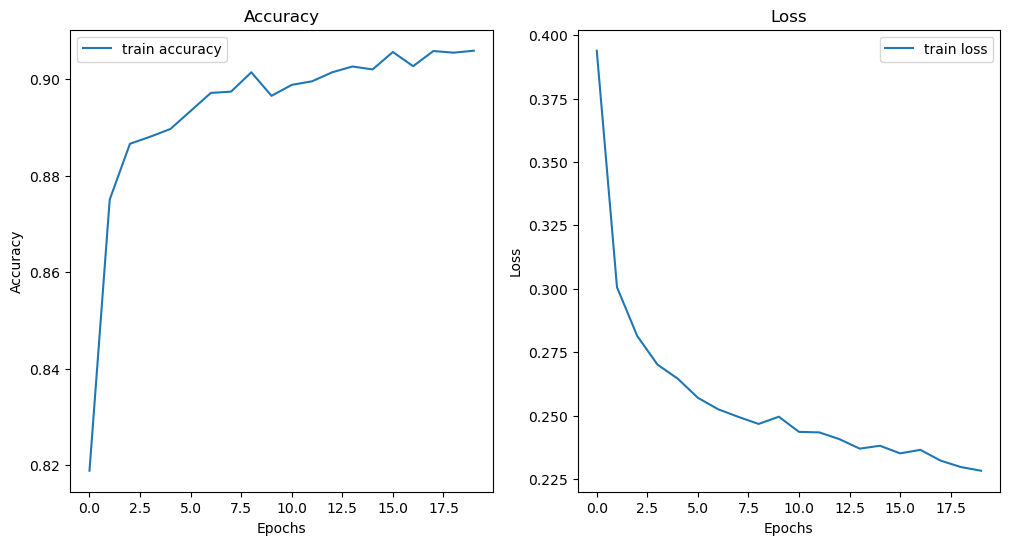

In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import ConvNeXtTiny
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# ==================== CONFIG ========================
IMG_SIZE = 160  # ConvNeXt requires 160x160 input size
BATCH_SIZE = 32
EPOCHS = 20
LEARNING_RATE = 1e-4  # Start with a low learning rate
NUM_CLASSES = 1  # Binary classification (Cancer or No Cancer)

# Define paths
train_images_dir = r"C:\ct data set\Pancreas-CT data\Merged_Clustered_Images"  # Path to your training images
output_model_dir = r"C:\ct data set\Pancreas-CT data\model_output"  # Path to save the trained model

# ==================== Load Training Data =======================
# Instead of loading all images into memory, use ImageDataGenerator for dynamic loading and resizing
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Normalize the images to [0, 1]
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    preprocessing_function=lambda x: tf.image.resize(x, (IMG_SIZE, IMG_SIZE))  # Resize dynamically
)

# Create ImageDataGenerator for training data
train_generator = train_datagen.flow_from_directory(
    train_images_dir,  # Replace with actual directory where the images are stored
    target_size=(IMG_SIZE, IMG_SIZE),  # Resize images to (160, 160)
    batch_size=BATCH_SIZE,
    class_mode='binary',  # For binary classification
    shuffle=True
)

# ==================== Load ConvNeXt Tiny ========================
base_model = ConvNeXtTiny(input_shape=(IMG_SIZE, IMG_SIZE, 3), include_top=False, weights='imagenet')

# Freeze the ConvNeXt layers initially
base_model.trainable = False

# ==================== Build Classifier ========================
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Global pooling to reduce dimensionality
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(NUM_CLASSES, activation='sigmoid')(x)  # Sigmoid for binary classification

# Create the final model
model = Model(inputs=base_model.input, outputs=x)

# ==================== Compile the Model ========================
model.compile(optimizer=Adam(learning_rate=LEARNING_RATE), loss='binary_crossentropy', metrics=['accuracy'])

# Show the model summary
model.summary()

# ==================== Train the Model ========================
history = model.fit(
    train_generator,
    epochs=EPOCHS
)

# ==================== Save the Trained Model ========================
# Ensure the output directory exists
os.makedirs(output_model_dir, exist_ok=True)

# Save the model in the output directory
model_save_path = os.path.join(output_model_dir, 'pancreatic_cancer_model.h5')
model.save(model_save_path)

print(f"✅ Model saved at {model_save_path}")

# ==================== Plot Training and Validation Accuracy/Loss ========================
plt.figure(figsize=(12, 6))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='train accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='train loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


In [3]:
# # Save the model in Keras .keras format
# model_save_path_keras = os.path.join(output_model_dir, 'pancreatic_cancer_model.keras')
# model.save(model_save_path_keras)

# print(f"✅ Model saved in Keras format at {model_save_path_keras}")


In [5]:
# import os

# # Define the output directory for saving the model
# output_model_dir = r"C:\ct data set\Pancreas-CT data\Saved_Models"

# # Create the directory if it doesn't exist
# os.makedirs(output_model_dir, exist_ok=True)

# # Save the model in Keras .keras format
# model_save_path_keras = os.path.join(output_model_dir, 'pancreatic_cancer_model.keras')
# model.save(model_save_path_keras)
# # 
# print(f"✅ Model saved in Keras format at {model_save_path_keras}")


In [1]:
from tensorflow import keras

model = keras.models.load_model(r'C:\ct data set\Pancreas-CT data\model_output\pancreatic_cancer_model.keras')



C:\anaconda\Lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 6 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [11]:
import tensorflow as tf

# Path to your saved model (.keras format)
model_save_path_keras = r'C:\ct data set\Pancreas-CT data\model_output\pancreatic_cancer_model.keras'

# Load the model
loaded_model = tf.keras.models.load_model(model_save_path_keras)

# Check model architecture
loaded_model.summary()


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 160, 160,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convnext_tiny_pres… │ (None, 160, 160,  │          0 │ input_layer[0][0] │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convnext_tiny_stem  │ (None, 40, 40,    │      4,896 │ convnext_tiny_pr… │
│ (Sequential)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convnext_tiny_stag… │ (None, 40, 40,    │      4,800 │ convnext_tiny_st… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convnext_tiny_stag… │ (None, 40, 40,    │        192 │ convnext_tiny_st… │
│ (LayerNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convnext_tiny_stag… │ (None, 40, 40,    │     37,248 │ convnext_tiny_st… │
│ (Dense)             │ 384)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convnext_tiny_stag… │ (None, 40, 40,    │          0 │ convnext_tiny_st… │
│ (Activation)        │ 384)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convnext_tiny_stag… │ (None, 40, 40,    │     36,960 │ convnext_tiny_st… │
│ (Dense)             │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convnext_tiny_stag… │ (None, 40, 40,    │         96 │ convnext_tiny_st… │
│ (LayerScale)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convnext_tiny_stag… │ (None, 40, 40,    │          0 │ convnext_tiny_st… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 40, 40,    │          0 │ convnext_tiny_st… │
│                     │ 96)               │            │ convnext_tiny_st… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convnext_tiny_stag… │ (None, 40, 40,    │      4,800 │ add[0][0]         │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convnext_tiny_stag… │ (None, 40, 40,    │        192 │ convnext_tiny_st… │
│ (LayerNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convnext_tiny_stag… │ (None, 40, 40,    │     37,248 │ convnext_tiny_st… │
│ (Dense)             │ 384)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convnext_tiny_stag… │ (None, 40, 40,    │          0 │ convnext_tiny_st… │
│ (Activation)        │ 384)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convnext_tiny_stag… │ (None, 40, 40,    │     36,960 │ convnext_tiny_st… │
│ (Dense)             │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convnext_tiny_stag… │ (None, 40, 40,    │         96 │ convnext_tiny_st

 Total params: 28,608,612 (109.13 MB)

 Trainable params: 394,241 (1.50 MB)

 Non-trainable params: 27,820,128 (106.13 MB)

 Optimizer params: 394,243 (1.50 MB)

In [14]:
import os
import numpy as np
from tqdm import tqdm
import glob

# Path to validation .npy files
val_npy_dir = r"C:\ct data set\Pancreas-CT data\Split_Data\val"

# Load all .npy files from val
val_files = sorted(glob.glob(os.path.join(val_npy_dir, "*.npy")))
print(f"📁 Found {len(val_files)} validation files")

# Load validation images
val_images = []
for path in tqdm(val_files, desc="📥 Loading Validation Images"):
    img = np.load(path)
    val_images.append(img)

# Expand dims for CNN input: (N, 128, 128, 1)
val_images = np.expand_dims(np.array(val_images), axis=-1)
print(f"✅ Loaded validation image shape: {val_images.shape}")

# Convert grayscale (128x128x1) to 3-channel (128x128x3)
val_images_rgb = np.repeat(val_images, 3, axis=-1)
print(f"🎨 Shape after conversion to RGB: {val_images_rgb.shape}")


📁 Found 2841 validation files


📥 Loading Validation Images: 100%|██████████| 2841/2841 [00:11<00:00, 257.27it/s]


✅ Loaded validation image shape: (2841, 128, 128, 1)
🎨 Shape after conversion to RGB: (2841, 128, 128, 3)


In [16]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
import numpy as np

# Convert grayscale (128x128x1) to 3-channel (128x128x3)
val_images_rgb = np.repeat(val_images, 3, axis=-1)

# Resize to MobileNetV2 input size (160x160)
val_images_resized = tf.image.resize(val_images_rgb, (160, 160)).numpy()

# Preprocess for MobileNetV2
val_images_preprocessed = preprocess_input(val_images_resized)

# Load MobileNetV2 (without top classifier)
base_model = MobileNetV2(input_shape=(160, 160, 3), include_top=False, weights='imagenet', pooling='avg')
base_model.trainable = False

# Extract features
val_features = base_model.predict(val_images_preprocessed, batch_size=64, verbose=1)
print(f"✅ Validation feature shape: {val_features.shape}")  # Should be (N, 1280)


45/45 ━━━━━━━━━━━━━━━━━━━━ 30s 620ms/step
✅ Validation feature shape: (2841, 1280)


In [18]:
from sklearn.cluster import KMeans
import numpy as np

# Perform clustering on extracted validation features
n_clusters = 2  # cancer / no cancer
kmeans_val = KMeans(n_clusters=n_clusters, random_state=42)
val_pseudo_labels = kmeans_val.fit_predict(val_features)

print(f"✅ Validation clustering complete. Labels distribution: {np.bincount(val_pseudo_labels)}")


✅ Validation clustering complete. Labels distribution: [2030  811]


In [20]:
import os
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np

# Output folder to save clustered validation images
val_output_root = r"C:\ct data set\Pancreas-CT data\Clustered_Val_Images"
os.makedirs(val_output_root, exist_ok=True)

# Create subfolders for each cluster
for cluster_id in np.unique(val_pseudo_labels):
    os.makedirs(os.path.join(val_output_root, f"cluster_{cluster_id}"), exist_ok=True)

# Save validation images into their respective cluster folders
for i, img_array in tqdm(enumerate(val_images[..., 0]), total=len(val_images), desc="📸 Saving clustered validation images"):
    cluster_id = val_pseudo_labels[i]
    save_path = os.path.join(val_output_root, f"cluster_{cluster_id}", f"image_{i:05d}.png")
    plt.imsave(save_path, img_array, cmap='gray')


📸 Saving clustered validation images: 100%|██████████| 2841/2841 [00:15<00:00, 187.64it/s]


In [22]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define constants
IMG_SIZE = 160
BATCH_SIZE = 32

# ==================== Setup Validation Data Generator ========================
val_datagen = ImageDataGenerator(rescale=1./255)  # Rescale the images to [0, 1]

# Replace with your validation data directory
val_directory = r"C:\ct data set\Pancreas-CT data\Clustered_Val_Images"

# Create ImageDataGenerator for validation data
val_generator = val_datagen.flow_from_directory(
    val_directory,  # Path to validation images directory
    target_size=(IMG_SIZE, IMG_SIZE),  # Resize images to (160, 160)
    batch_size=BATCH_SIZE,
    class_mode='binary',  # For binary classification
    shuffle=False  # Don't shuffle for evaluation
)

# ==================== Evaluate the Model ========================
val_loss, val_accuracy = model.evaluate(val_generator)

# Output the validation results
print(f"Validation Accuracy: {val_accuracy*100:.2f}%")
print(f"Validation Loss: {val_loss:.4f}")


Found 2841 images belonging to 2 classes.


C:\anaconda\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


89/89 ━━━━━━━━━━━━━━━━━━━━ 511s 6s/step - accuracy: 0.9609 - loss: 0.1248
Validation Accuracy: 94.19%
Validation Loss: 0.1478


In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import numpy as np

# Define constants
IMG_SIZE = 160
BATCH_SIZE = 32

# ==================== Setup Validation Data Generator ========================
val_datagen = ImageDataGenerator(rescale=1./255)  # Rescale the images to [0, 1]

# Replace with your validation data directory
val_directory = r"C:\ct data set\Pancreas-CT data\Clustered_Val_Images"

# Create ImageDataGenerator for validation data
val_generator = val_datagen.flow_from_directory(
    val_directory,  # Path to validation images directory
    target_size=(IMG_SIZE, IMG_SIZE),  # Resize images to (160, 160)
    batch_size=BATCH_SIZE,
    class_mode='binary',  # For binary classification
    shuffle=False  # Don't shuffle for evaluation
)

# ==================== Predict on the Validation Set ====================
# Using the val_generator for predictions on validation data
y_pred = model.predict(val_generator, verbose=1)

# Convert predictions to binary values (e.g., 0 or 1)
y_pred_binary = (y_pred > 0.5).astype(int)  # 0.5 threshold for binary classification

# Get true labels from the validation generator
y_true = val_generator.classes  # This will be an array of ground truth labels (0 or 1)

# ==================== Calculate Precision, Recall, F1-Score ====================
# Precision
precision = precision_score(y_true, y_pred_binary)

# Recall
recall = recall_score(y_true, y_pred_binary)

# F1-Score
f1 = f1_score(y_true, y_pred_binary)

# Confusion Matrix (optional, for more detailed performance evaluation)
cm = confusion_matrix(y_true, y_pred_binary)

# ==================== Output the Results ====================
print(f"🔵 Precision: {precision:.4f}")
print(f"🟢 Recall: {recall:.4f}")
print(f"⚖️ F1-Score: {f1:.4f}")
print(f"📊 Confusion Matrix:\n{cm}")


Found 2841 images belonging to 2 classes.


C:\anaconda\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


89/89 ━━━━━━━━━━━━━━━━━━━━ 731s 8s/step
🔵 Precision: 0.9078
🟢 Recall: 0.8866
⚖️ F1-Score: 0.8971
📊 Confusion Matrix:
[[1957   73]
 [  92  719]]



✅ Model loaded successfully!
Found 2841 images belonging to 2 classes.


C:\anaconda\Lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 6 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
C:\anaconda\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


89/89 ━━━━━━━━━━━━━━━━━━━━ 568s 6s/step

🔵 Precision: 0.9078
🟢 Recall: 0.8866
⚖️ F1-Score: 0.8971

📊 Classification Report:
              precision    recall  f1-score   support

     Class 0       0.96      0.96      0.96      2030
     Class 1       0.91      0.89      0.90       811

    accuracy                           0.94      2841
   macro avg       0.93      0.93      0.93      2841
weighted avg       0.94      0.94      0.94      2841



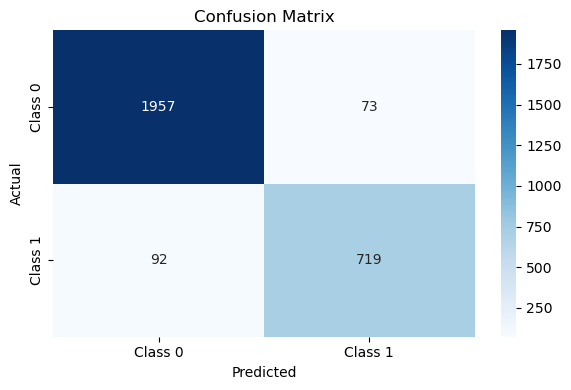

In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# ==================== Configuration ====================
IMG_SIZE = 160
BATCH_SIZE = 32

# ==================== Load Trained Model ====================
model_path = r"C:\ct data set\Pancreas-CT data\model_output\pancreatic_cancer_model.keras"
model = tf.keras.models.load_model(model_path)
print("✅ Model loaded successfully!")

# ==================== Setup Validation Data ====================
val_directory = r"C:\ct data set\Pancreas-CT data\Clustered_Val_Images"

val_datagen = ImageDataGenerator(rescale=1./255)

val_generator = val_datagen.flow_from_directory(
    val_directory,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

# ==================== Prediction ====================
y_pred_probs = model.predict(val_generator, verbose=1)
y_pred = (y_pred_probs > 0.5).astype(int).flatten()
y_true = val_generator.classes

# ==================== Metrics ====================
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
cm = confusion_matrix(y_true, y_pred)

print(f"\n🔵 Precision: {precision:.4f}")
print(f"🟢 Recall: {recall:.4f}")
print(f"⚖️ F1-Score: {f1:.4f}")
print("\n📊 Classification Report:")
print(classification_report(y_true, y_pred, target_names=["Class 0", "Class 1"]))

# ==================== Confusion Matrix Plot ====================
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Class 0", "Class 1"], yticklabels=["Class 0", "Class 1"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()


89/89 ━━━━━━━━━━━━━━━━━━━━ 492s 6s/step - accuracy: 0.9609 - loss: 0.1248


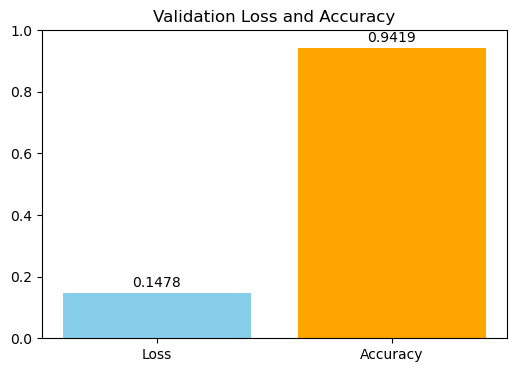

In [5]:
import matplotlib.pyplot as plt

# Evaluate once
val_loss, val_accuracy = model.evaluate(val_generator)

# Plot single point (bar graph)
plt.figure(figsize=(6, 4))
metrics = ['Loss', 'Accuracy']
values = [val_loss, val_accuracy]

bars = plt.bar(metrics, values, color=['skyblue', 'orange'])
plt.ylim(0, 1)
plt.title('Validation Loss and Accuracy')

# Add value labels
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + 0.01, f'{yval:.4f}', ha='center', va='bottom')

plt.show()


C:\anaconda\Lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 6 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


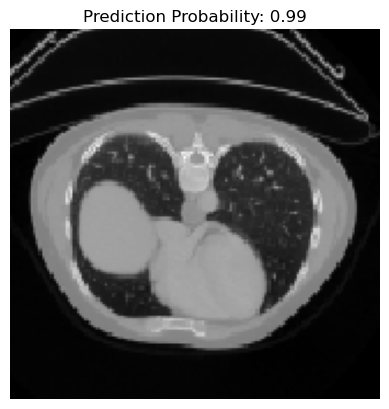

🔵 Prediction: Cancer Detected (Confidence: 99.33%)


In [2]:
import os
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

# ====================== Load the Trained Model ======================
model_path = r"C:\ct data set\Pancreas-CT data\model_output\pancreatic_cancer_model.keras"
model = tf.keras.models.load_model(model_path)

# ====================== Pre-compiled Prediction Function ======================
@tf.function(reduce_retracing=True)
def model_predict(img_array):
    return model(img_array, training=False)

# ====================== Prediction Function ======================
def predict_image(img_path):
    # Check if the file exists
    if not os.path.exists(img_path):
        print(f"❌ Error: The image at {img_path} does not exist.")
        return

    # Load and preprocess the image
    img = image.load_img(img_path, target_size=(160, 160))  # Resize
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # (1, 160, 160, 3)
    img_array = img_array / 255.0  # Normalize to [0,1]

    # Predict
    preds = model_predict(img_array)
    probability = preds.numpy()[0][0]

    # Display the image
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Prediction Probability: {probability:.2f}")
    plt.show()

    # Interpretation
    if probability > 0.5:
        print(f"🔵 Prediction: Cancer Detected (Confidence: {probability*100:.2f}%)")
    else:
        print(f"🟢 Prediction: No Cancer Detected (Confidence: {(1 - probability)*100:.2f}%)")

# ====================== Example Usage ======================
img_path = r"C:\ct data set\Pancreas-CT data\Clustered_Images\cluster_0\image_02320.png"# Your image path
predict_image(img_path)
